In [38]:
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

# This is required to catch warnings when the multiprocessing module is used
import os

os.environ["PYTHONWARNINGS"] = "ignore"
import pertpy as pt
import scanpy as sc
import anndata
import pandas as pd
from modules.deg_analysis import *
from modules.visualize import *

In [39]:
sample_tag_mapping = {'SampleTag17_flex':'WT-DMSO',
                      'SampleTag18_flex':'3xTg-DMSO',
                      'SampleTag19_flex':'WT-SCDi',
                      'SampleTag20_flex':'3xTg-SCDi',
                      'Undetermined':'Undetermined',
                      'Multiplet':'Multiplet'}
adata = anndata.read_h5ad('data/fede_count.h5ad')
adata.obs['Sample_Tag'] = adata.obs['Sample_Tag'].map(sample_tag_mapping)
adata = adata[adata.obs['Sample_Tag'] != "Multiplet", :]
adata = adata[adata.obs['Sample_Tag'] != "Undetermined", :]
adata = adata[adata.obs['Sample_Tag'] != "3xTg-DMSO", :]
adata = adata[adata.obs['Sample_Tag'] != "3xTg-SCDi", :]
anno_df = pd.read_csv("data/fede_mapping.csv", skiprows=4)

In [40]:
adata = annotate_adata(adata, anno_df)

In [41]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.obs['high_mt'] = adata.obs['pct_counts_mt'] > 50

In [42]:
sc.pp.filter_cells(adata, min_genes=150)
sc.pp.filter_genes(adata, min_cells=3)

In [43]:
adata = adata[~adata.obs['high_mt'], :]
adata = adata[adata.obs['Sample_Tag'] != "Multiplet", :]

In [44]:
adata.obs.rename({"Sample_Tag": "condition"}, axis=1, inplace=True)
#adata.obs["condition"].replace({"ctrl": "control", "stim": "stimulated"}, inplace=True)

In [45]:
ag_rfc = pt.tl.Augur("random_forest_classifier")

In [46]:
loaded_data = ag_rfc.load(adata, label_col="condition", cell_type_col="class_name")

In [47]:
v_adata, v_results = ag_rfc.predict(
    loaded_data, subsample_size=20, n_threads=4, select_variance_features=True, span=1
)

v_results["summary_metrics"]

Set smaller span value in the case of a `segmentation fault` error.

Set larger span in case of svddc or other near singularities error.

Skipping MB cell type - the number of samples for at least one class type is less than subsample size 20.

Skipping P cell type - 49 samples is less than min_cells 50.

Skipping DG-IMN cell type - 26 samples is less than min_cells 50.

Skipping LSX cell type - 14 samples is less than min_cells 50.

Skipping CNU-LGE cell type - 14 samples is less than min_cells 50.

Skipping MB-HB cell type - 9 samples is less than min_cells 50.

Skipping CNU-HYa cell type - the number of samples for at least one class type is less than subsample size 20.

Skipping NP-CT-L6b cell type - 14 samples is less than min_cells 50.

Skipping CTX-CGE cell type - 2 samples is less than min_cells 50.

Skipping MY cell type - the number of samples for at least one class type is less than subsample size 20.

Skipping Pineal cell type - 15 samples is less than min_cells 50.

Skipping CTX-MGE cell type - 9 samples is less than min_cells 50.

Skipping CB cell type - 24 samples is less than min_cells 50.

Skipping CNU-MGE cell type - 12 samples is less than min_cells 50.

Skipping TH cell type - 20 samples is less than min_cells 50.

Skipping OB-CR cell type - 6 samples is less than min_cells 50.

Skipping MH-LH cell type - 2 samples is less than min_cells 50.

,Astro-Epen,Immune,Vascular,OPC-Oligo,OEC,HY,OB-IMN,IT-ET
mean_augur_score,0.682891,0.589535,0.571746,0.600907,0.793798,0.741735,0.703186,0.795964
mean_auc,0.682891,0.589535,0.571746,0.600907,0.793798,0.741735,0.703186,0.795964
mean_accuracy,0.608205,0.563187,0.518938,0.543516,0.616777,0.619927,0.578278,0.635897
mean_precision,0.656000,0.566316,0.518333,0.536004,0.819664,0.731775,0.631490,0.783862
mean_f1,0.536961,0.514975,0.460429,0.484028,0.380302,0.446572,0.336929,0.423605
mean_recall,0.548571,0.532222,0.473651,0.508889,0.278571,0.371270,0.274127,0.320635


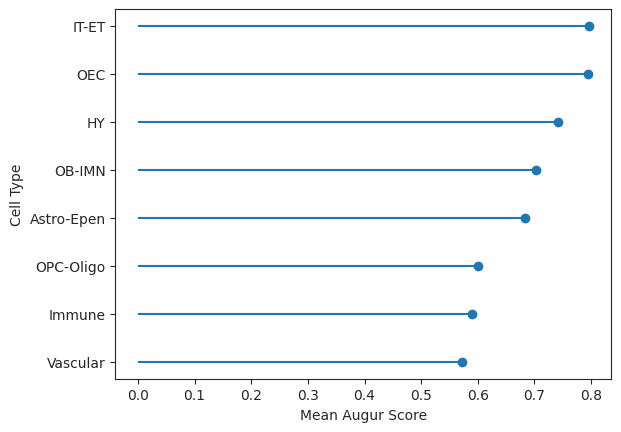

In [48]:
lollipop = ag_rfc.plot_lollipop(v_results)

In [49]:
v_adata.X = v_adata.X.astype(np.float64)

In [50]:
sc.pp.normalize_total(v_adata)
sc.pp.log1p(v_adata)
sc.pp.pca(v_adata, n_comps=10)

sc.pp.neighbors(v_adata)
sc.tl.umap(v_adata)

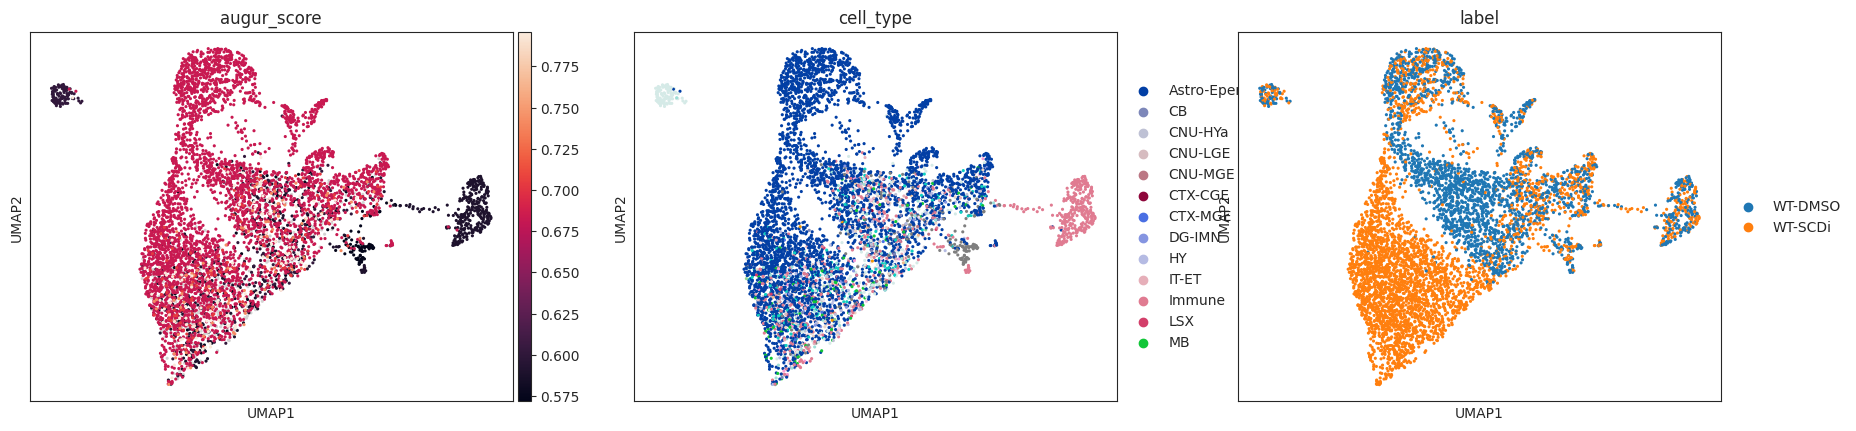

In [51]:
sc.pl.umap(adata=v_adata, color=["augur_score", "cell_type", "label"])

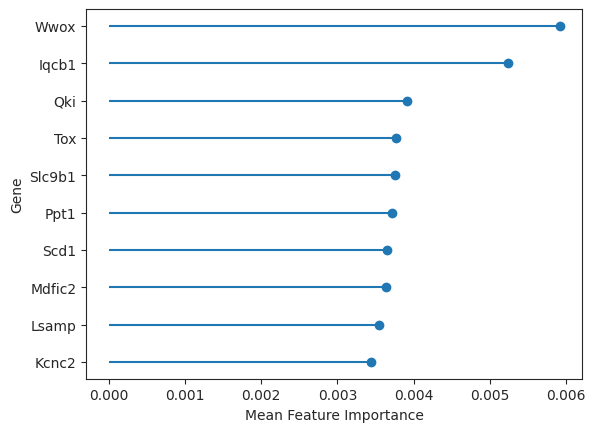

In [52]:
important_features = ag_rfc.plot_important_features(v_results)